# Abstract - Summary
Below is contains Python code that imports the data described in the ReadMe, cleans it, categorizes it as appropriate, and performs multiple linear regression on it.

# Introduction
The data is a pretty lean data set, and was originally intended for insurance information. Fortunately, is also has a lot of other fields that are relevant to 

# Research Questions
Can you predict the miles per gallon a car gets in the city based on the data available in the data set?
That is the primary question being addressed by this project. The secondary questions are what's affecting this the most (positively or negatively). The followu-up question, which is out of the scope of this project, are "can we optimize mpg better, now that we know what has an affect on it." There may me minor design decisions that we could make for cars that improve fuel economy without sacrificing other important outcomes/performance of cars. Further understanding how this data is correlated could help answer that question.

# EDA(Exploratory Data Analysis)
I used some seaborn plots to check out how drive wheel, engine size, and aspiration affected city fuel economy. I did this to get a feel for the data, but it was largely informational and did not affect the OLS modeling technique I employed, further described below.

# Data Cleaning
Data cleaning centered around couple functions to categorize some qualitative data. This included the fuel injection system and the number of cyliders (to group them), which were both done through lambda functions. The make of the car was categorized qualitatively, with a conventional function. There was some data removed later on, during the modeling, such as bore and stroke. This is explained more below.

Index(['Symboling', 'Normalized-Losses', 'Make', 'Fuel-Type', 'Aspiration',
       'Num-of-doors', 'Body-style', 'Drive-wheels', 'Engine-location',
       'Wheel-base', 'Length', 'Width', 'Height', 'Curb-weight', 'Engine-type',
       'Num-of-cylinders', 'Engine-size', 'Fuel-system', 'Bore', 'Stroke',
       'Compression-ratio', 'Horsepower', 'Peak-rpm', 'City-mpg',
       'Highway-mpg', 'Price', 'Cat-make', 'Cat-fuel-system',
       'Cat-Num-Cylinders'],
      dtype='object')

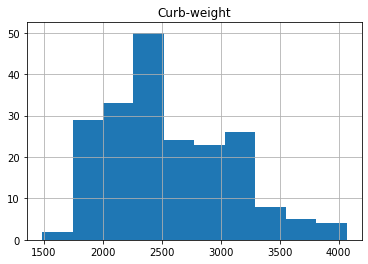

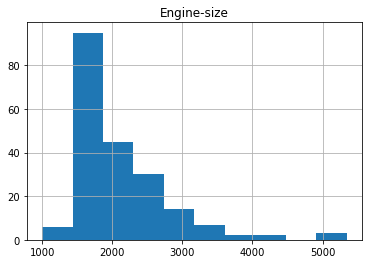

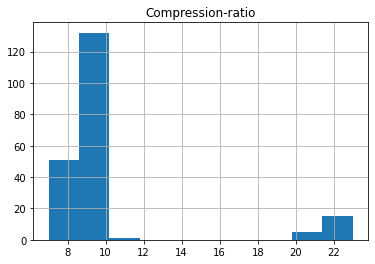

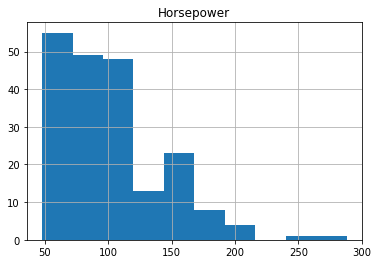

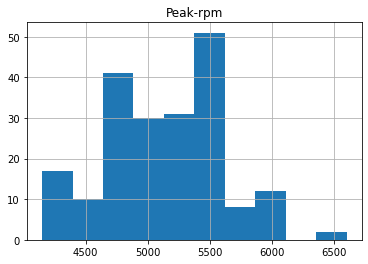

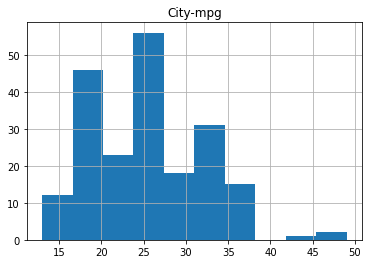

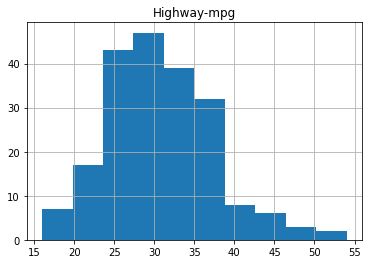

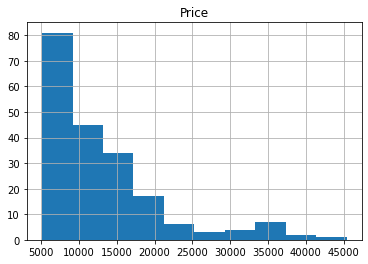

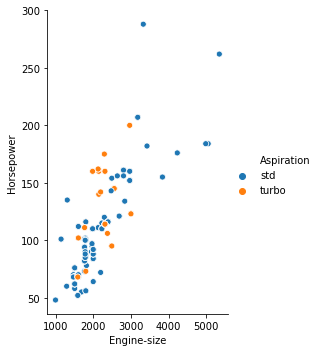

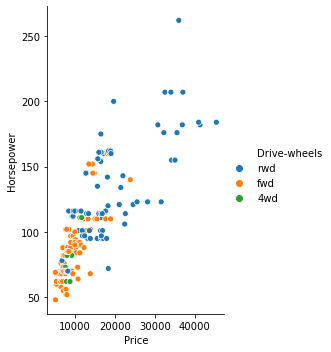

In [1]:
import pandas as pd
import numpy as np
data= pd.read_csv("imports-85.data")

data.columns =['Symboling', 'Normalized-Losses', 'Make', 'Fuel-Type' , 'Aspiration' ,\
               'Num-of-doors' , 'Body-style' , 'Drive-wheels' , 'Engine-location' ,\
               'Wheel-base' , 'Length' , 'Width' , 'Height' , 'Curb-weight' ,\
               'Engine-type' , 'Num-of-cylinders' , 'Engine-size' , 'Fuel-system' , 'Bore' ,\
                'Stroke' , 'Compression-ratio' , 'Horsepower' , 'Peak-rpm' , 'City-mpg' , \
               'Highway-mpg' , 'Price'] #wow it actually worked ;)
data = data.replace('?', np.nan)

data['Engine-size'] = data['Engine-size']*16.3871 #converting from cubic inches to cubic centimeters
#The three below fields were strings in the csv file- converting them to float
data['Horsepower'] = pd.to_numeric(data['Horsepower'])
data['Peak-rpm'] = pd.to_numeric(data['Peak-rpm'])
data['Price'] = pd.to_numeric(data['Price'])

##Categorizing make of each car
def make_classifier(make):
    if make in ('honda' , 'isuzu' , 'mazda' , 'mitsubishi' , 'nissan' , 'peugot' , 'renault' , 'subaru' , 'toyota' , 'volkswagen'):
         return 'budget'
    elif make in ('saab' , 'volvo'):
        return 'scandanavian'
    elif make in ('chevrolet' , 'dodge' , 'mercury' , 'plymouth'):
        return 'american'
    elif make in ('audi' , 'alfa-romero' , 'bmw' , 'porsche' , 'jaguar' , 'mercedes-benz'):
        return 'luxury'
    else:
        return 'error'
#Analyzing data via histograms
data.hist('Curb-weight')
data.hist('Engine-size')
data.hist('Compression-ratio') 
#     print(data[data['Compression-ratio'] > 15]) all of these are diesels, which is why their compression ratio is so high
data.hist('Horsepower')
data.hist('Peak-rpm')
data.hist('City-mpg')
data.hist('Highway-mpg')
data.hist('Price')
data['Cat-make'] = data['Make'].apply(make_classifier)

#Plotting some variables to check out what some of the relationships are
import seaborn as sns
sns.relplot(x="Engine-size", y="Horsepower", aspect=.7 , hue='Aspiration' , kind="scatter", data=data)
sns.relplot(x="Price", y="Horsepower", aspect=.7 , hue='Drive-wheels' , kind="scatter", data=data)

## Categorizing fuel injection systems with a lambda function
data['Cat-fuel-system'] = data['Fuel-system'].apply(lambda x: 'Injection' if x=='mpfi' else ('Diesel' if x== 'idi' else 'Carbureted'))

## Categorizing on number of cylinders
data['Cat-Num-Cylinders'] = data['Num-of-cylinders'].apply(lambda x: '< Five' if x==('four' or 'two') else ('Five or Six' if x==('five' or 'six') else 'Eight or more'))
data.columns



# data.shape



In [2]:
data_dummied = pd.get_dummies(data, columns=['Cat-make','Fuel-Type','Aspiration','Num-of-doors','Body-style','Drive-wheels','Engine-location','Cat-fuel-system','Engine-type','Cat-Num-Cylinders'])
data_dummied = data_dummied.drop([129, 130]) #these rows have NaN values
# data_dummied.head()
# data.head()

# Feature Engineering
Some feature engineering was performed; for example, there was insurance data that was relevant to the original mission of the data, but not relevant for this exercise. Also not relevant was the price, because I intend for this to be able to run on pre-production vehicles. There was some data removed (bore and stroke), as those are dimensions of the engine, but we already had engine displacement, which is just a function of these two features. 

# Modeling
Below is the multiple linear regression model. Some of the columns were dropped before running the model, as I had either accounted for them with categorized dummy variables, or they were otherwise undesired for the model.

Then I ran the model, and identified features that had high p-values. I would remove the highest p-value, then I would run the model again. I iterated this until I got the p-values down to be no higher than 0.01. I am left with 9 features, and their respective coefficients:
    Wheel-base                     1.2593
    Length                        -1.8747
    Curb-weight                   -3.2296
    Compression-ratio              2.7238
    Horsepower                    -1.0288
    Aspiration_std                 8.8553
    Aspiration_turbo               7.3131
    Cat-fuel-system_Carbureted     1.6574
    Engine-type_rotor             -9.5900

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

#Removed data that I had either created categorized dummy variables for, was redundant, or wouldn't be an independent variable (City-mpg, for example) (bore and stroke are too closely related to engine size)
X = data_dummied.drop(columns = ['Make','Symboling','Normalized-Losses','Fuel-system','Bore', 'Stroke','City-mpg', 'Highway-mpg','Price','Num-of-cylinders'])

#ran the model,iterating and removing values that have a p value of >0.05
X= X.drop(columns=['Engine-type_ohcv','Body-style_convertible','Body-style_convertible','Body-style_hardtop','Engine-type_ohcf','Width','Height','Cat-fuel-system_Diesel','Fuel-Type_diesel','Num-of-doors_four','Cat-make_luxury','Cat-make_budget','Drive-wheels_4wd','Drive-wheels_rwd','Body-style_hatchback','Engine-location_rear','Engine-location_front','Engine-size','Engine-type_ohc','Engine-type_l','Cat-make_scandanavian','Engine-type_dohc','Cat-Num-Cylinders_Five or Six','Engine-type_dohcv','Cat-Num-Cylinders_< Five','Cat-Num-Cylinders_Eight or more','Drive-wheels_fwd','Body-style_sedan','Num-of-doors_two','Body-style_wagon','Peak-rpm','Cat-make_american','Cat-fuel-system_Injection','Fuel-Type_gas'])

scale_col = ['Wheel-base','Length', 'Curb-weight','Compression-ratio','Horsepower']
scaler = StandardScaler()
X[scale_col] = scaler.fit_transform(X[scale_col])

y = data['City-mpg'] #is is what I'm predicting
y= y.drop([129,130]) # these rows have NaN values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

##Perfoming linear regression here
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train, X_train_sm).fit()

# OLS results
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:               City-mpg   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     138.7
Date:                Thu, 29 Oct 2020   Prob (F-statistic):           7.65e-66
Time:                        12:51:49   Log-Likelihood:                -359.55
No. Observations:                 161   AIC:                             737.1
Df Residuals:                     152   BIC:                             764.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               


# Model Evaluation & Selection
This model shows a R-squared value of 0.88 and no p-values above 0.01, show it proves that it is a good predictor of the outcome (city-mpg), and that each of the features left has a strong correlation with that outcome.


# Conclusions - Interpretations 
This model is successful at descriving the relationships between the features described above and the city miles per gallon. From previous knowledge on cars and their mileage, these features make sense. The feature/outcome example that makes the most sense is weight is strongly negatively correlated with city fuel economy. During city driving, the cars mass has to be repeatledly accelerated (weight hardly affects highway mileage, becase this is not the case). 

In addition, high compression ratio is typically means the engine can operate more efficiently, and can result in higher mileage. Another feature whose influence was not suprising was rotary engines; rotary engines are known for poor fuel economy, so it makes sense that it has a highly negative coefficient. Aspiration has high coefficents (std and turbo), but aspiration is either turbo or standard (there were no supercharged vehicles in the data set), and the coefficients are pretty similar, so they don't affect the outcome much. I left them in because their p-value was so low that it meant they were still greatly influencing the model.

I would say the biggest surprise to me was that the aspiration didn't more greatly affect the city mpg, as during city driving the engine is under more load, and the turbo is used more. The other surprise to me was that compression ratio didn't negatively affect city fuel economy, as it's often associated with high performance cars that don't prioritize fuel economy. These are some takeaways that could help influence car design to optimize fuel economy while minimizing tradeoffs.